In [40]:
import os
import sys
import random
from typing import *

import numpy as np
import matplotlib.pyplot as plt

import nnbma
from torch import nn, optim
from nnbma import LearningParameters, learning_procedure, RegressionDataset, RegressionSubset

import infovar
from infovar.stats import MI, Condh, LinearInfo, LinearInfoGauss

sys.path.insert(0, os.path.join(".."))
sys.path.insert(1, os.path.join("..", "data"))

from orion_util import get_lines, get_params
from helpers import prepare_data

def fano_bound(condh):
    return 1/(2*np.pi*np.e) * np.exp(2*condh)

In [41]:
# Load and preprocess data
    
all_line_names, all_param_names = get_lines(), get_params()
lines, params = prepare_data(all_line_names, all_param_names)

lines, params = lines, params


class Getter:

    line_names = all_line_names
    param_names = all_param_names
    lines = lines
    params = params

    @classmethod
    def getter(
        cls,
        x_features: List[str], y_features: List[str],
        restrictions: Dict[str, Tuple[float]],
        max_samples: Optional[int]=None,
        seed: Optional[int]=None
    ):
        lines_idx = [cls.line_names.index(v) for v in x_features]
        _lines = np.column_stack([
            cls.lines[:, i] for i in lines_idx
        ])

        params_idx = [cls.param_names.index(v) for v in y_features]
        _params = np.column_stack([
            cls.params[:, i] for i in params_idx
        ])
        
        filt = np.ones(_params.shape[0], dtype="bool")

        # Remove non-finite pixels in variables
        filt &= np.isfinite(_lines).all(axis=1)

        # Remove pixels out of the targets ranges (including NaNs)
        for key, (low, upp) in restrictions.items():
            if key in cls.line_names:
                i = cls.line_names.index(key)
                filt &= np.logical_and(
                    cls.lines[:, i] >= low,
                    cls.lines[:, i] <= upp
                )
            elif key in cls.param_names:
                i = cls.param_names.index(key)
                filt &= np.logical_and(
                    cls.params[:, i] >= low,
                    cls.params[:, i] <= upp
                )

        _lines = _lines[filt]
        _params = _params[filt]
        
        if max_samples is None or _lines.shape[0] <= max_samples:
            return _lines, _params
        
        idx = list(range(_lines.shape[0]))

        random.seed(seed)
        random.shuffle(idx)
        idx = idx[:max_samples]

        return _lines[idx, :], _params[idx, :]

In [42]:
y_features = ["av"]
restrictions = {"av": [1, 15]}
max_samples = 100_000

In [43]:
mi = MI()
condh = Condh()
linfo = LinearInfo() # LinearInfoGauss()

In [36]:
x_features_list = [
    ["13co10"],
    ["c18o10"],
    ["n2hp10"],
    ["13co10", "c18o10"],
    ["13co10", "n2hp10"],
    ["c18o10", "n2hp10"]
]

In [44]:
hs = []
mis = []
fanos = []
linfos = []
for x_features in x_features_list:
    print(x_features)

    x, y = Getter.getter(
        x_features,
        y_features,
        restrictions,
        max_samples
    )

    y = np.log10(y)

    hs.append(
        condh(x, y)
    )

    mis.append(
        mi(x, y)
    )

    fanos.append(
        fano_bound(hs[-1])
    )

    linfos.append(
        linfo(x, y)
    )

['13co10']
['c18o10']
['n2hp10']
['13co10', 'c18o10']
['13co10', 'n2hp10']
['c18o10', 'n2hp10']


In [23]:
hidden_layers = [] # [50, 20]
activation = nn.ELU()

loss_fun = nn.MSELoss()
epochs = 20
batch_size = 100

mses = []
for x_features in x_features_list:

    x, y = Getter.getter(
        x_features,
        y_features,
        restrictions,
        max_samples
    )

    y = np.log10(y)

    layers_sizes = [len(x_features)] + hidden_layers + [len(y_features)]
    net = nnbma.FullyConnected(
        layers_sizes=layers_sizes,
        activation=activation
    )

    learning_params = LearningParameters(
        loss_fun=loss_fun,
        epochs=epochs,
        batch_size=batch_size,
        optimizer=optim.Adam(net.parameters())
    )

    dataset = RegressionDataset(
        x, y
    )

    idx = list(range(len(dataset)))
    train_set = RegressionSubset(dataset, idx[10:])
    val_set = RegressionSubset(dataset, idx[:10])

    learning_procedure(
        net, (train_set, val_set), learning_params
    )

    y_hat = net.evaluate(x)

    mses.append(
        np.mean( (y_hat-y)**2 )
    )

Epoch: 100%|██████████| 20/20 [00:43<00:00,  2.19s/it]


Epoch: 100%|██████████| 20/20 [00:40<00:00,  2.04s/it]


Epoch: 100%|██████████| 20/20 [00:40<00:00,  2.00s/it]


Epoch: 100%|██████████| 20/20 [00:39<00:00,  2.00s/it]


Epoch: 100%|██████████| 20/20 [00:39<00:00,  1.97s/it]


Epoch: 100%|██████████| 20/20 [00:39<00:00,  1.96s/it]

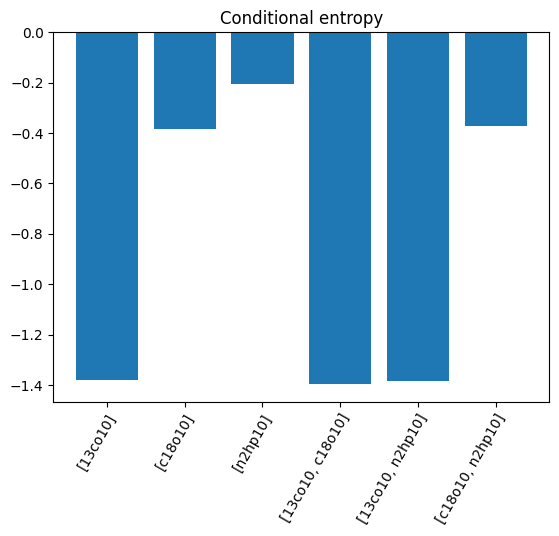

In [24]:
xticks = np.arange(len(x_features_list))
xticklabels = [str(comb).replace("'", "") for comb in x_features_list]

plt.bar(xticks, hs)
plt.xticks(xticks, xticklabels, rotation=60, ha='right', rotation_mode='anchor')
plt.title("Conditional entropy")

plt.show()

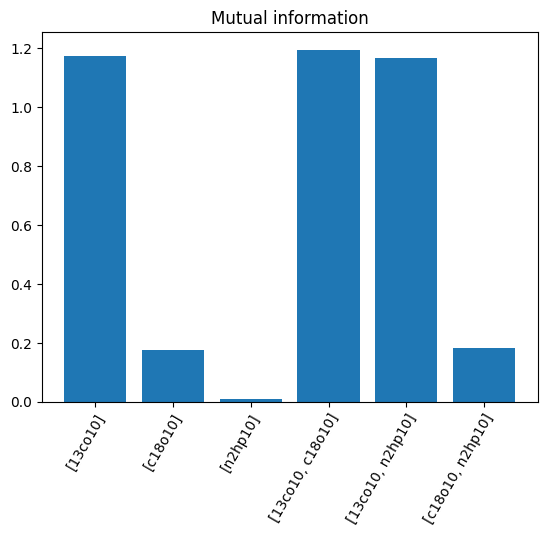

In [25]:
plt.bar(xticks, mis)
plt.xticks(xticks, xticklabels, rotation=60, ha='right', rotation_mode='anchor')
plt.title("Mutual information")

plt.show()

In [ ]:
plt.bar(xticks, linfos)
plt.xticks(xticks, xticklabels, rotation=60, ha='right', rotation_mode='anchor')
plt.title("Mutual information (gaussian assumption)")

plt.show()

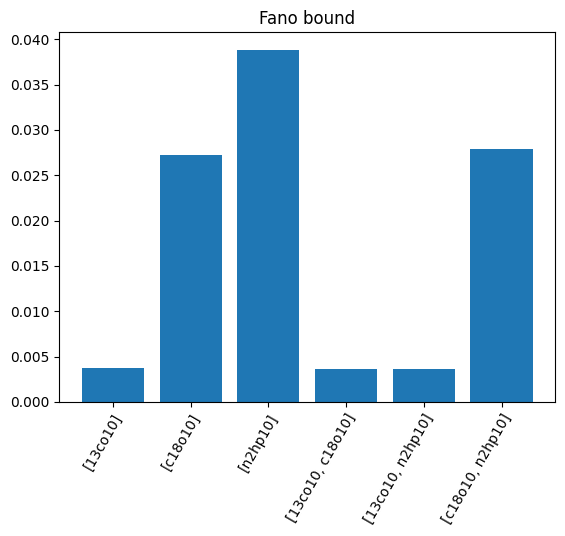

In [26]:
plt.bar(xticks, fanos)
plt.xticks(xticks, xticklabels, rotation=60, ha='right', rotation_mode='anchor')
plt.title("Fano bound")

plt.show()

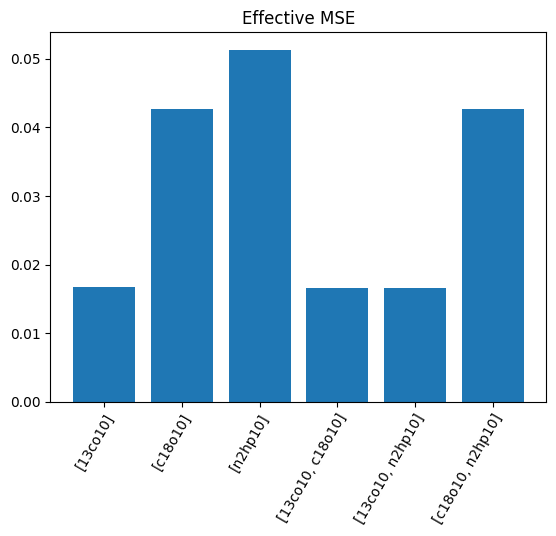

In [27]:
plt.bar(xticks, mses)
plt.xticks(xticks, xticklabels, rotation=60, ha='right', rotation_mode='anchor')
plt.title("Effective MSE")

plt.show()

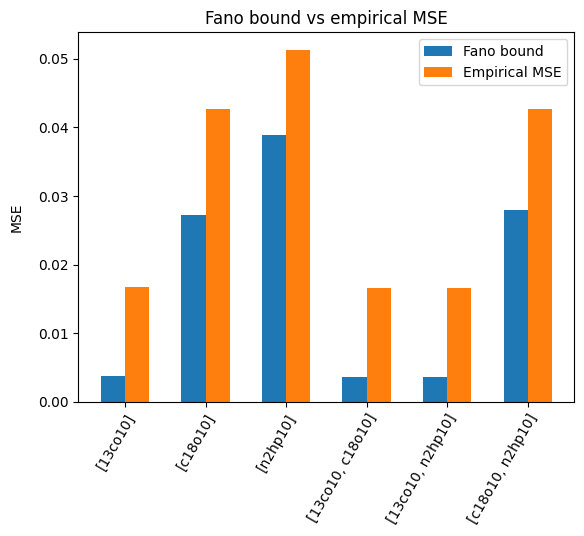

In [28]:
barwidth = 0.3

fig, ax = plt.subplots()

ax.bar(xticks-barwidth/2, fanos, color="tab:blue", width=barwidth, label="Fano bound")
ax.bar(xticks+barwidth/2, mses, color="tab:orange", width=barwidth, label="Empirical MSE")

ax.set_xticks(xticks, xticklabels, rotation=60, ha='right', rotation_mode='anchor')
ax.set_ylabel("MSE", labelpad=10)
plt.title("Fano bound vs empirical MSE")

ax.legend()

plt.show()

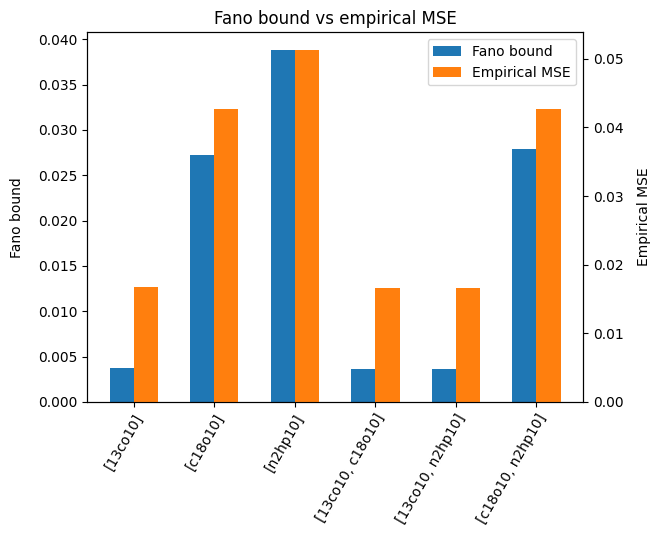

In [29]:
barwidth = 0.3

fig, ax = plt.subplots()

ax2 = ax.twinx()

b1 = ax.bar(xticks-barwidth/2, fanos, color="tab:blue", width=barwidth, label="Fano bound")
b2 = ax2.bar(xticks+barwidth/2, mses, color="tab:orange", width=barwidth, label="Empirical MSE")

ax.set_xticks(xticks, xticklabels, rotation=60, ha='right', rotation_mode='anchor')
ax.set_ylabel("Fano bound", labelpad=10)
ax2.set_ylabel("Empirical MSE", labelpad=10)
plt.title("Fano bound vs empirical MSE")

labs = [b1.get_label(), b2.get_label()]
ax.legend([b1, b2], labs)

plt.show()

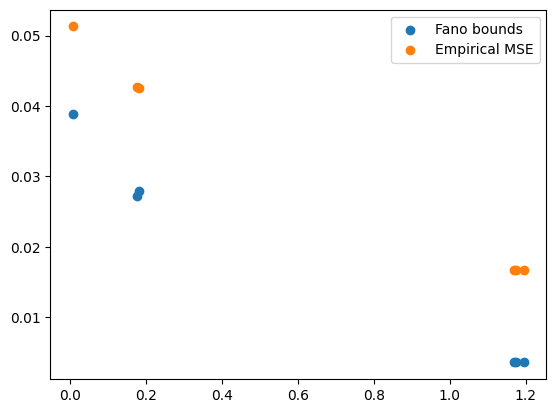

In [30]:
plt.scatter(mis, fanos, label="Fano bounds")
plt.scatter(mis, mses, label="Empirical MSE")

plt.legend()

plt.show()

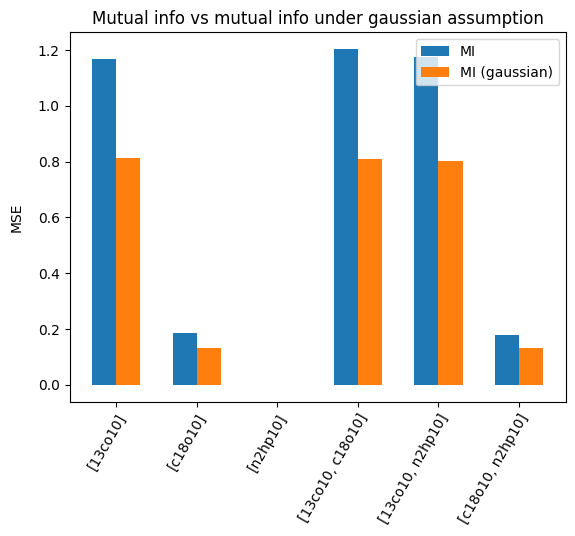

In [45]:
barwidth = 0.3

fig, ax = plt.subplots()

ax.bar(xticks-barwidth/2, mis, color="tab:blue", width=barwidth, label="MI")
ax.bar(xticks+barwidth/2, linfos, color="tab:orange", width=barwidth, label="MI (gaussian)")

ax.set_xticks(xticks, xticklabels, rotation=60, ha='right', rotation_mode='anchor')
ax.set_ylabel("MSE", labelpad=10)
plt.title("Mutual info vs mutual info under gaussian assumption")

ax.legend()

plt.show()